
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [24]:
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [25]:
# This cell allows full compatibility between execution in Google Colab and in local
# try:
#   import google.colab.files
#   IN_COLAB = True
# except:
#   IN_COLAB = False
# # from google.colab import files
# if IN_COLAB:
#     uploaded = files.upload()

In [26]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = '../datasets/FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [27]:
df0.describe()

,hhsize,adults_n,children_n,totalexp,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
mean,2.363707,1.841807,0.521901,519.898868,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,0.743052,0.945622,411.543093,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,0.000000,0.000000,-246.916821,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,1.000000,0.000000,260.598783,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,2.000000,0.000000,426.977227,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,2.000000,1.000000,651.003763,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561
max,9.000000,7.000000,7.000000,5859.877186,2014.0,2134.090000,80.000000,104.589333,41.348362,169.283829,803.465027,194.869995,480.024994,40.000000,46.315834,32.666668


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [28]:
print(f'Number of rows: {len(df0)}')
print(f'Number of null-containing rows: {len(df0) - len(df0.dropna())}')

Number of rows: 5114
Number of null-containing rows: 1668


#### Drop rows with nulls

In [29]:
df1 = df0.dropna().copy()
print(f'Number of rows after dropping null values: {len(df1)}')

Number of rows after dropping null values: 3446


##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [30]:
df1['SexHRP'] = df1['SexHRP'].apply(lambda x: 1 if x == 'Male' else 0)

df1['qmeat_hhsize_ratio'] = df1['qmeat'] / df1['hhsize']
df1['income_hhsize_ratio'] = df1['income'] / df1['hhsize']

##### Use only the columns that the experts consider interesting
This is suggested by background information

In [34]:
df = df1[['adults_n', 'children_n', 'SexHRP', 'AgeHRP'
        , 'qmeat_hhsize_ratio', 'income_hhsize_ratio', 'uvmeat']]

In [35]:
df.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [36]:
target = 'qmeat_hhsize_ratio'
X = df.drop(target, axis=1)
y = df[target]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [37]:
ncols=3
import math
nrows = math.ceil((df.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

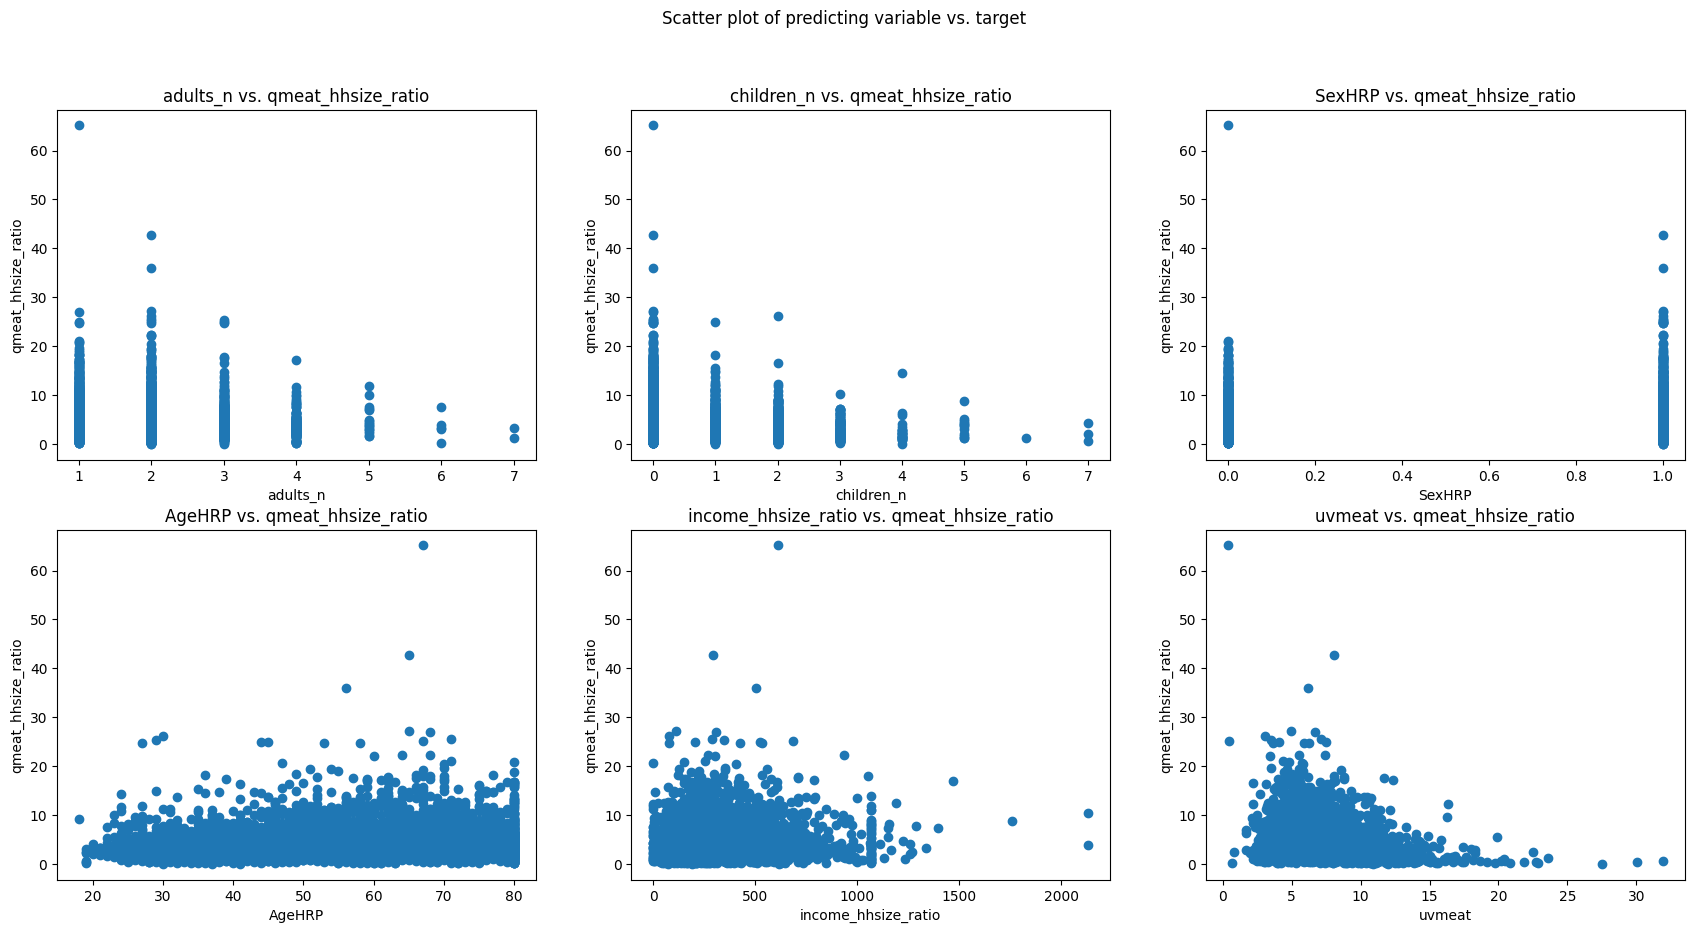

In [38]:
plt.figure(figsize=(figwidth, figheigth))
i = 1
plt.suptitle("Scatter plot of predicting variable vs. target")
for col in X:
    plt.subplot(nrows, ncols, i)
    plt.scatter(X[col], y)
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f'{col} vs. {target}')
    i += 1

### Show the *_p-values_* of the target with respect to the variables

In [39]:
from sklearn.feature_selection import f_regression
# Your code here
_, p_values = f_regression(X, y)
p_values_show = pd.DataFrame({'Variable': X.columns, 'p-value': p_values})
p_values_show

,Variable,p-value
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03
5,uvmeat,4.789746e-52


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [42]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, train_size=0.7, random_state=random_state)
print(f'Training with {len(Xtrain)} samples')
print(f'Testing with {len(Xtest)} samples')

Training with 2412 samples
Testing with 1034 samples


### Consider a reduced dataset containing the chosen variable and the target

In [43]:
pred_var = 'adults_n'

Xtrain_r = Xtrain[pred_var].values.reshape(-1, 1)
Xtest_r = Xtest[pred_var].values.reshape(-1, 1)

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [46]:
linear_uni = linear_model.LinearRegression()
linear_uni.fit(Xtrain_r, Ytrain);
y_train_pred_uni = linear_uni.predict(Xtrain_r)
y_test_pred_uni = linear_uni.predict(Xtest_r)

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [47]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs, sn=.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE 
    MST = SST / DFT
    F = MSM / MSE
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic 
    return F, p

#### Compute the statistical significance of the model

In [50]:
f_statistic_uni, p_value_uni = f_test(Ytrain, y_train_pred_uni,
                                        Xtrain_r.shape[1], Xtest_r.shape[0])

coeff_uni = linear_uni.coef_[0]
intercept_uni = linear_uni.intercept_

rmse_uni = mean_squared_error(Ytest, y_test_pred_uni, squared=False)
r2_uni = r2_score(Ytest, y_test_pred_uni)

pd.DataFrame({
    'Univariate Linear - Value':[
        intercept_uni,
        coeff_uni,
        rmse_uni,
        r2_uni,
        f_statistic_uni,
        p_value_uni
    ]}, index=[
        f'Intercept for {pred_var}',
        f'Coefficient for {pred_var}',
        'RMSE',
        'R2',
        'F-statistic',
        'p-value'
    ])

,Univariate Linear - Value
Intercept for adults_n,5.646984
Coefficient for adults_n,-0.326893
RMSE,3.886323
R2,0.007595
F-statistic,4.214141
p-value,0.040340


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [51]:
linear_multi = linear_model.LinearRegression()
linear_multi.fit(Xtrain, Ytrain);
y_train_pred_multi = linear_multi.predict(Xtrain)
y_test_pred_multi = linear_multi.predict(Xtest)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [52]:
pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': linear_multi.coef_
})

,Variable,Coefficient
0,adults_n,-0.318682
1,children_n,-0.650924
2,SexHRP,0.383162
3,AgeHRP,0.014913
4,income_hhsize_ratio,0.000989
5,uvmeat,-0.392620


#### Compute the statistical significance

In [53]:
_, p_values = f_regression(Xtrain, y_train_pred_multi)
p_values_show = pd.DataFrame({'Variable': X.columns, 'p-value': p_values})
p_values_show

,Variable,p-value
0,adults_n,4.812836e-19
1,children_n,1.384315e-188
2,SexHRP,5.806116e-10
3,AgeHRP,3.199609e-119
4,income_hhsize_ratio,6.460728e-08
5,uvmeat,0.000000e+00


#### Compute the quality measures

In [57]:
f_statistic_multi, p_value_multi = f_test(
    Ytrain,
    y_train_pred_multi,
    Xtrain.shape[1],
    Xtest.shape[0]
)
rmse_multi = mean_squared_error(Ytest, y_test_pred_multi, squared=False)
r2_multi = r2_score(Ytest, y_test_pred_multi)

pd.DataFrame({
    'Multivariate Linear - Value':[
        rmse_multi,
        r2_multi,
        f_statistic_multi,
        p_value_multi
    ]}, index=[
        'RMSE',
        'R2',
        'F-statistic',
        'p-value'
    ])

,Multivariate Linear - Value
RMSE,3.665149e+00
R2,1.173381e-01
F-statistic,2.451900e+01
p-value,1.110223e-16


## Decision Tree Multivariate Regresson

In [58]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [59]:
dt = DecisionTreeRegressor(random_state=random_state)
dt.fit(Xtrain, Ytrain);
max_depth = dt.get_depth()
print(f'Decision Tree with max_depth={max_depth}')

Decision Tree with max_depth=34


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [62]:
from sklearn.model_selection import GridSearchCV

In [65]:
param_grid = {'max_depth': list(range(1, max_depth))}

dt_gscv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error')

dt_gscv.fit(Xtrain, Ytrain);
dt_best = dt_gscv.best_estimator_
print(f'Best Decision Tree with max_depth={dt_best.get_depth()}')

Best Decision Tree with max_depth=2


#### Show the tree

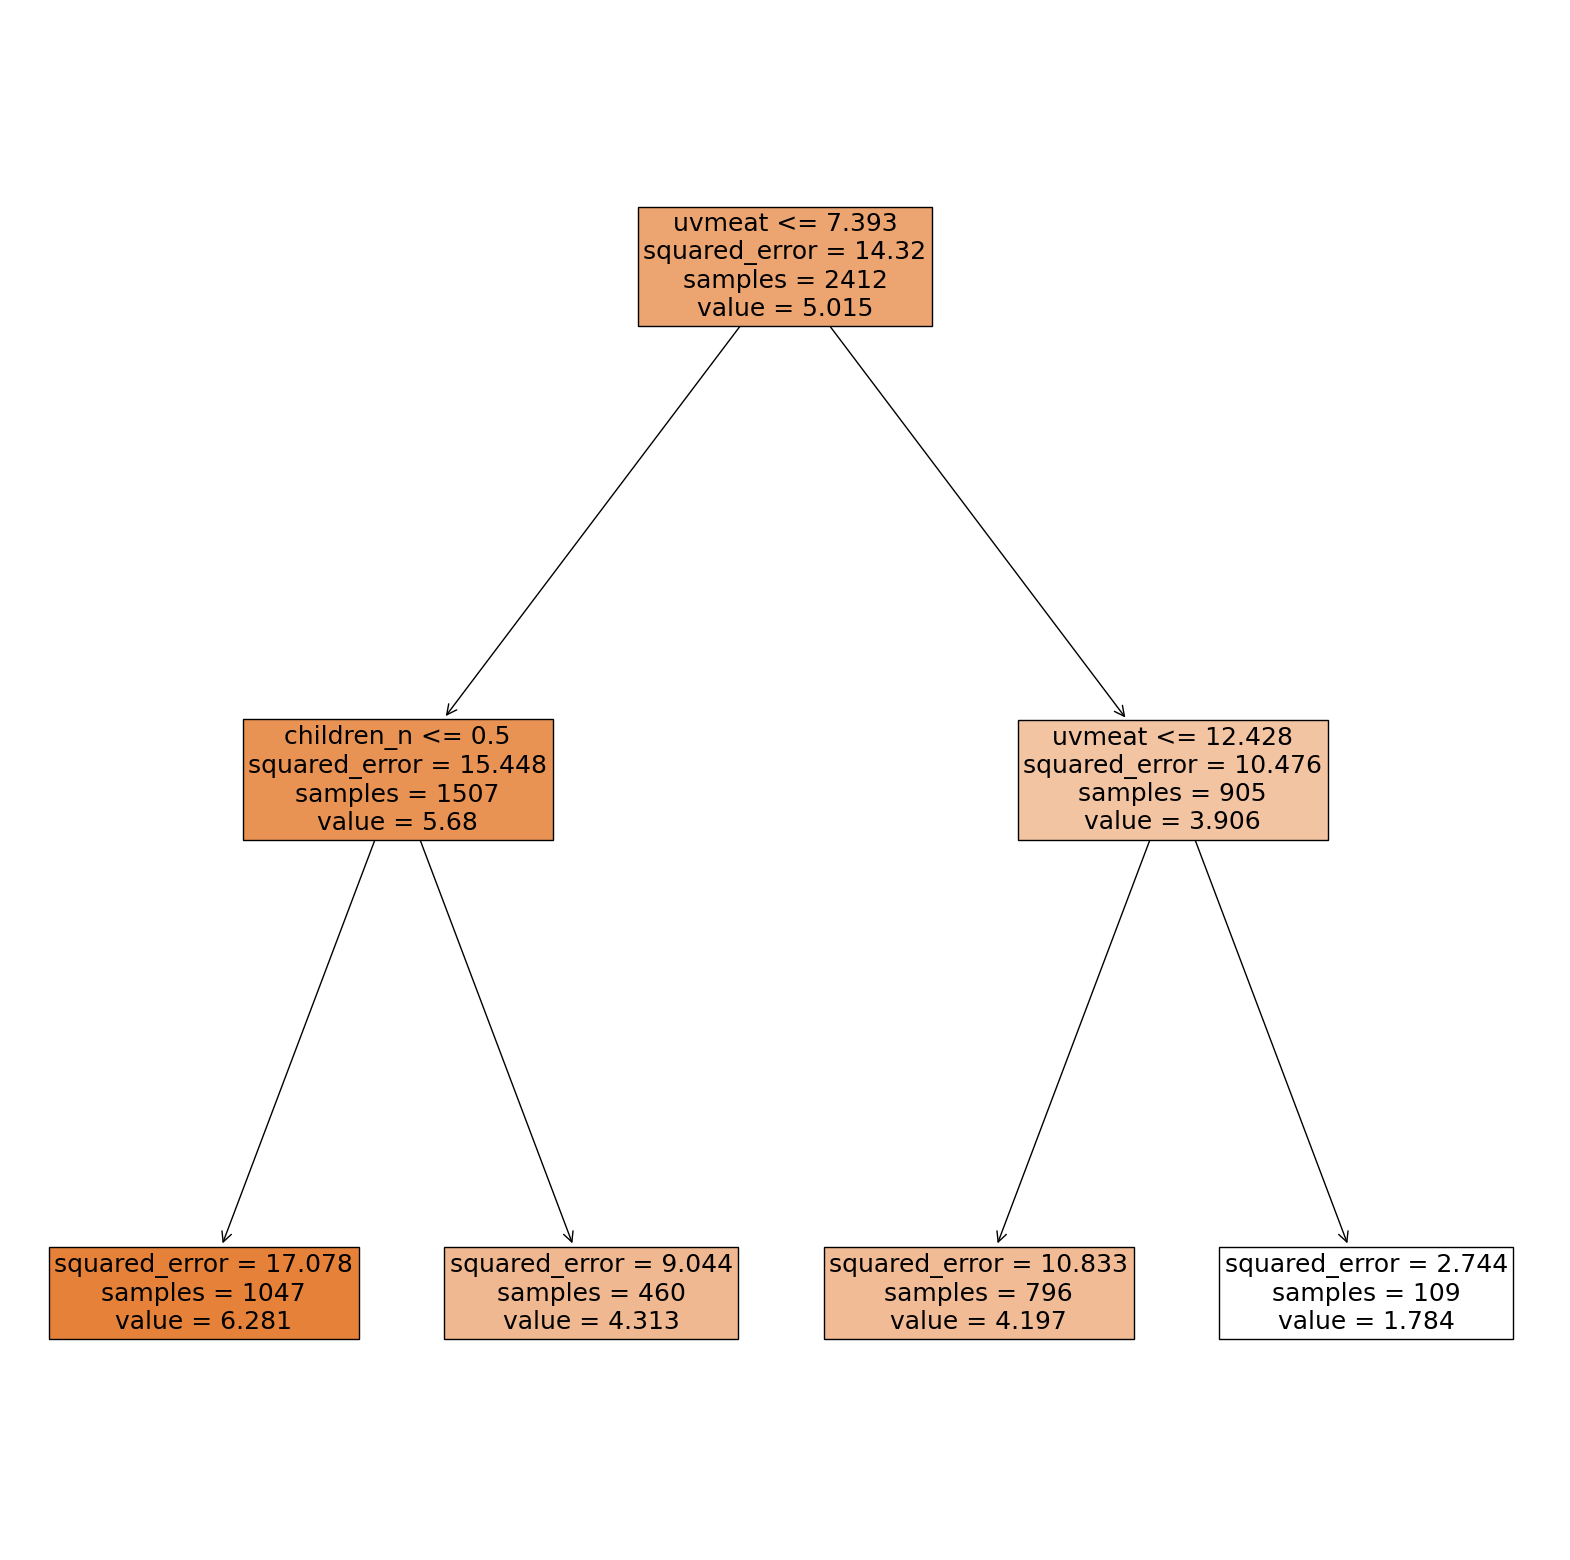

In [69]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here

figure(figsize=(20, 20))
plot_tree(dt_best, filled=True, feature_names=X.columns, fontsize=18);

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

In [73]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state)

param_grid_rf = {
    'max_depth': list(range(1, max_depth))}

rf_gscv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error')

rf_gscv.fit(Xtrain, Ytrain);
rf_best = rf_gscv.best_estimator_
print(f'Best Random Forest with max_depth={rf_best.max_depth}')

Best Random Forest with max_depth=4


In [75]:
y_test_pres_rf = rf_best.predict(Xtest)
rmse_rf = mean_squared_error(Ytest, y_test_pres_rf, squared=False)
print(f'RMSE for Random Forest: {round(rmse_rf,2)}')

RMSE for Random Forest: 3.58


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results